In [21]:
try:
  import distrax
except ModuleNotFoundError:
  %pip install distrax
  import distrax
try:
  import jax
except ModuleNotFoundError:
  %pip install jax 
  import jax

import jax.numpy as jnp
try:
  import matplotlib.pyplot as plt
except ModuleNotFoundError:
  %pip install matplotlib 
  import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

try:
  from tqdm import tqdm
except ModuleNotFoundError:
  %pip install tqdm
  from tqdm import tqdm


try: 
  import jaxopt
except ModuleNotFoundError:
  %pip install jaxopt
  import jaxopt

import optax
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [22]:
def rbf(x, x_star, len_scale_, varf_):
  sqdist = jnp.sum(x**2,1).reshape(-1,1) + jnp.sum(x_star**2,1) - 2*jnp.dot(x, x_star.T)
  return varf_*jnp.exp(-.5 * (1/len_scale_) * sqdist)

def NLL(theta,x,y):
  len_scale_ = jnp.exp(theta["log_scale"])
  varf_ = jnp.exp(theta["log_varf"])
  k = rbf(x,x,len_scale_, varf_)
  k = k + ( jnp.exp(theta["log_vary"]) * jnp.eye(len(x)))
  mean_vec= jnp.zeros(y.shape[0])
  dist = distrax.MultivariateNormalFullCovariance(mean_vec, k)
  dist_logprob = dist.log_prob(y.reshape(-1,))
 
  return -dist_logprob

In [14]:
def SGD(x, y, theta, batch_size, alpha, epochs):
  nll_epoch = []
  var_signal = []
  var_noise = []
  theta1 = theta
  lr = alpha
  nll_gradient = jax.jit(jax.grad(NLL, argnums = 0))

  
  if (len(x) % batch_size  == 0):
    num_batches = int(len(x)/batch_size)
  else:
    num_batches = int((len(x)/batch_size)) + 1

  
  tx = optax.adam(lr)
  neigh = NearestNeighbors(n_neighbors=batch_size, algorithm='kd_tree')
  neigh.fit(x)
  _,neigh_idx = neigh.kneighbors(x, batch_size)
    
  for i in range(epochs):
    
    ## use tfds for shuffling
    batch_index = 0
    X_, Y_ = jax.random.shuffle(key_, x), jax.random.shuffle(key, y)

  
    for k in range(num_batches):
      opt_state1 = tx.init((theta1["log_scale"]))
      opt_state2 = tx.init((theta1["log_varf"]))
      opt_state3 = tx.init((theta1["log_vary"]))

      ## Random batches
      # if batch_index+batch_size > len(X_):
      #    X_batch, Y_batch = X_[batch_index:,:], Y_[batch_index:,:]
      # else:
      #   X_batch, Y_batch = X_[batch_index:batch_index+batch_size,:], Y_[batch_index:batch_index+batch_size,:]
      
      ## NN batches
      center_idx  = jax.random.randint(key_,(1,), 1, len(y))
      nn_batch_indices =  neigh_idx[center_idx,]
      nn_batch_X  = X[nn_batch_indices,].reshape(-1,1)
      nn_batch_y  = Y[nn_batch_indices].reshape(-1,1)

      # grads = nll_gradient(theta1, X_batch, Y_batch)
      grads = nll_gradient(theta1,  nn_batch_X,  nn_batch_y)


      updates1,opt_state1 = tx.update(grads["log_scale"], opt_state1)
      theta1["log_scale"] = optax.apply_updates((theta1["log_scale"]), updates1)
      updates2,opt_state2 = tx.update(((batch_size*grads["log_varf"])/(3*jnp.log(batch_size))), opt_state2)
      theta1["log_varf"] = optax.apply_updates((theta1["log_varf"]), updates2)
      updates3,opt_state3 = tx.update(grads["log_vary"], opt_state3)
      theta1["log_vary"] = optax.apply_updates((theta1["log_vary"]), updates3)

      nll_epoch.append(NLL(theta1,X_, Y_))
      var_signal.append(jnp.exp(theta1["log_varf"]))
      var_noise.append(jnp.exp(theta1["log_vary"]))

      # lr = lr/(k+1)


  print(NLL(theta1,X_, Y_))
  print(jnp.exp(theta1["log_scale"]), jnp.exp(theta1["log_varf"]), jnp.exp(theta1["log_vary"]))

  return nll_epoch, var_signal, var_noise


 10%|█         | 1/10 [00:55<08:17, 55.31s/it]

2647.9905301941317
0.49998400107876295 5.000003778082618 3.000000613873171


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 20%|██        | 2/10 [01:16<04:42, 35.26s/it]

2084.1664418448577
0.49999650685468416 5.000003531418931 3.000000596307773


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 30%|███       | 3/10 [01:38<03:23, 29.12s/it]

2397.967135852326
0.49999742528391233 5.000003162912214 3.0000006403011295


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 40%|████      | 4/10 [02:07<02:54, 29.03s/it]

2336.8404816354346
0.49999485564843515 5.000006297900038 3.0000006561439267


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 50%|█████     | 5/10 [02:28<02:10, 26.08s/it]

2356.9357019918584
0.499994350328485 5.000007176103746 3.000000594613549


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 60%|██████    | 6/10 [02:57<01:48, 27.23s/it]

2267.2176610422366
0.4999906316692031 5.000009681581664 3.0000006667386487


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 70%|███████   | 7/10 [03:17<01:14, 24.70s/it]

2360.0022890750224
0.499996093218996 5.000003429795021 3.00000059483648


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 80%|████████  | 8/10 [04:10<01:07, 33.81s/it]

2397.967135852326
0.49999742528391233 5.000003162912214 3.0000006403011295


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 90%|█████████ | 9/10 [04:50<00:35, 35.73s/it]

2562.9286332494694
0.5000184561503487 5.0000143377995485 3.000000595184314


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
100%|██████████| 10/10 [05:27<00:00, 32.79s/it]

3007.4207277278942
0.49999977235141585 328299902.23545444 3.00000073160929



 10%|█         | 1/10 [00:25<03:47, 25.26s/it]

2561.171443507975
0.5000105927387519 2.5000033787384917 3.5000006772490586


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 20%|██        | 2/10 [00:49<03:16, 24.50s/it]

2077.5415677174724
0.4999940966150838 2.5000028714371987 3.500000658742767


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 30%|███       | 3/10 [01:18<03:08, 26.90s/it]

2347.853969467726
0.4999960574134974 2.5000037740972347 3.500000699225459


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.


2846.855882970504
0.4999995466317685 164149924.32958156 3.5000007378789677


 50%|█████     | 5/10 [02:13<02:11, 26.36s/it]

2872.336713953778
0.4999996091908318 164149936.39625722 3.5000006828826953


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 60%|██████    | 6/10 [02:49<01:58, 29.72s/it]

10618.834123890834
7.61490860950036e-09 164149922.40516695 25.761708951413908


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 70%|███████   | 7/10 [03:17<01:27, 29.22s/it]

2315.4774930989197
0.4999941011366784 2.5000022620957285 3.5000006577770977


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 80%|████████  | 8/10 [03:37<00:52, 26.18s/it]

2347.853969467726
0.4999960574134974 2.5000037740972347 3.500000699225459


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 90%|█████████ | 9/10 [03:57<00:24, 24.32s/it]

52738187456.71466
0.4999998583967771 2.5000000198970285 5.4738152874326154e-08


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
100%|██████████| 10/10 [04:16<00:00, 25.66s/it]

2929.980636819392
0.4999997559738718 164149953.03007126 3.5000007864398825



 10%|█         | 1/10 [00:29<04:22, 29.18s/it]

5473.989580204186
0.5096959250626947 2.4999936152064834 0.699999933895922


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.


3098.3587115663695
1490.30349852832 2.500000877530316 0.6999999933535171


 30%|███       | 3/10 [01:54<04:39, 39.93s/it]

4402.9636073699485
0.5004362325832963 2.4999857087427855 0.6999999141317106


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 40%|████      | 4/10 [02:29<03:48, 38.12s/it]

4136.830694382593
0.5000031662967255 2.4999981657796613 0.6999999495224648


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 50%|█████     | 5/10 [03:19<03:31, 42.35s/it]

4226.451647928501
0.5000282305400799 2.4999960042568694 0.6999997769519088


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 60%|██████    | 6/10 [03:49<02:32, 38.20s/it]

3841.193638954519
0.500002837970319 2.4999990716412572 0.6999999591311991


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 70%|███████   | 7/10 [04:18<01:44, 34.95s/it]

4441.377458090497
0.49979852478341247 0.0008386634386551593 0.6999999947423278


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 80%|████████  | 8/10 [04:40<01:01, 30.91s/it]

4402.9636073699485
0.5004362325832963 2.4999857087427855 0.6999999141317106


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 90%|█████████ | 9/10 [06:04<00:47, 47.57s/it]

5110.836448466611
0.5000003565441756 2.499999530265121 0.6999996745150615


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
100%|██████████| 10/10 [06:56<00:00, 41.65s/it]

4579.368424270225
0.5000018949281151 2.49999992125491 0.6999999756395762


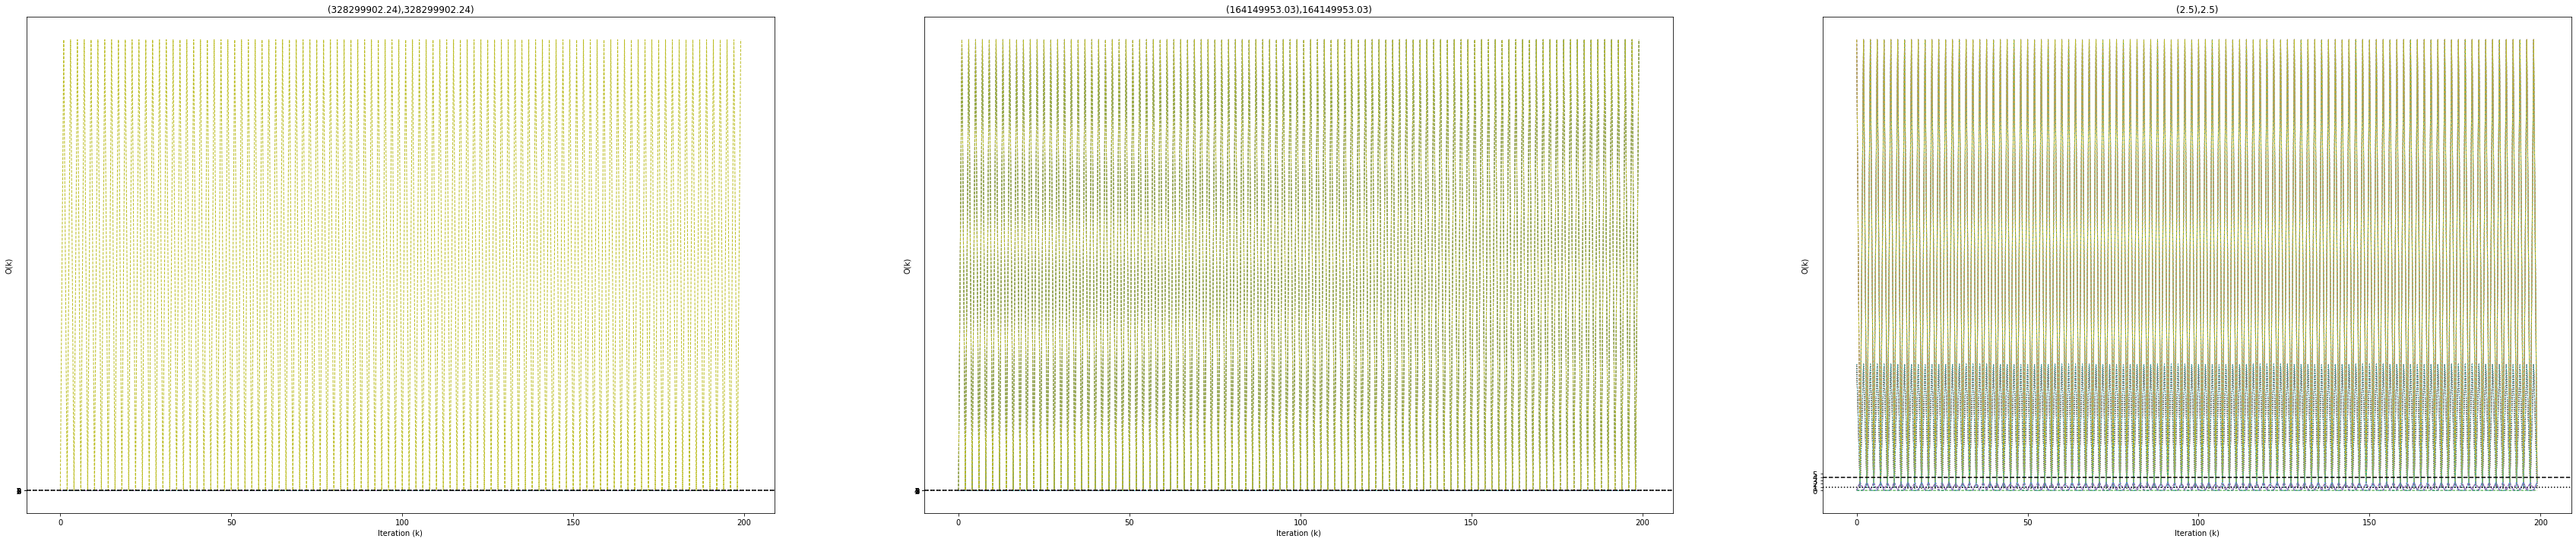

In [15]:
batch_size = 128
N = 1024
alpha_arr = [9, 9, 4]

fig,ax = plt.subplots(1,3,figsize=(60,12))

seed = np.random.randint(100, size=10)

for  j in range(3):
  
  for t in tqdm(range(10)):
    theta_init = [{"log_varf": jnp.log(5.),"log_vary": jnp.log(3.),"log_scale": jnp.log(0.5)},
                  {"log_varf": jnp.log(2.5),"log_vary": jnp.log(3.5),"log_scale": jnp.log(0.5)},
                  {"log_varf": jnp.log(2.5),"log_vary": jnp.log(0.7),"log_scale": jnp.log(0.5)}]

    theta_ = theta_init[j]
    alpha_ = alpha_arr[j] 

    key_ = jax.random.PRNGKey(seed[t])

    X_dist = distrax.Normal(0.0,5.0)
    X = X_dist.sample(seed=key_, sample_shape = (1024,)).reshape(-1,1)
    # print(X.shape)

    varf = 4.0
    len_scale = 0.5
    vary = 1.0

    cov = rbf(X, X, len_scale,  varf)  +   vary * jnp.eye(len(X))
    mean_vec = jnp.zeros(1024,)
    Y_dist = distrax.MultivariateNormalFullCovariance(mean_vec, cov)
    Y = Y_dist.sample(seed=key).reshape(-1,1)
    # print(Y.shape)

    loss, param1, param2 = SGD(X, Y, theta_, batch_size, alpha_, 25)

    # ax[].plot(loss, label='loss')
    ax[j].plot(param1, linestyle='dashed', linewidth=1, markersize=12)
    ax[j].plot(param2, linestyle='dotted', linewidth=1, markersize=10)

  ax[j].axhline(y = 4, color = 'black', linestyle = 'dashed')
  ax[j].axhline(y = 1, color = 'black', linestyle = ':')
  ax[j].set_xlabel('Iteration (k)')
  ax[j].set_ylabel('O(k)')
  ax[j].set_title(f'({round(jnp.exp(theta_["log_varf"]).item(),2)}),{round(jnp.exp(theta_["log_varf"]).item(),2)})')
  ax[j].set_xticks([0,50,100,150,200])
  ax[j].set_yticks([0,1,2,3,4,5])
 
  
plt.savefig('figure1.png')

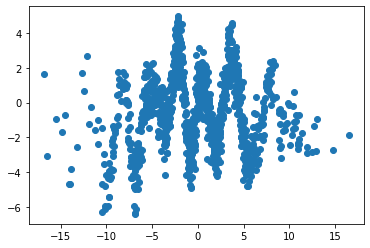

In [20]:
key_ = jax.random.PRNGKey(1)

X_dist = distrax.Normal(0.0,5.0)
X = X_dist.sample(seed=key_, sample_shape = (1024,)).reshape(-1,1)
# print(X.shape)

varf = 4.0
len_scale = 0.5
vary = 1.0

cov = rbf(X, X, len_scale,  varf)  +   vary * jnp.eye(len(X))
mean_vec = jnp.zeros(1024,)
Y_dist = distrax.MultivariateNormalFullCovariance(mean_vec, cov)
Y = Y_dist.sample(seed=key).reshape(-1,1)

plt.scatter(X,Y)